### Effective Radius Comparison

Compare forward model with different wavelengths and reffs.

In [1]:
#imports

import at3d
import numpy as np
import xarray as xr
from collections import OrderedDict
import pylab as py
np.random.seed(1)

cloud_scatterer = at3d.util.load_from_csv('../data/synthetic_cloud_fields/jpl_les/rico32x37x26.txt',
                                           density='lwc',origin=(0.0,0.0))

#load atmosphere
atmosphere = xr.open_dataset('../data/ancillary/AFGL_summer_mid_lat.nc')
#subset the atmosphere, choose only the bottom four km.
reduced_atmosphere = atmosphere.sel({'z': atmosphere.coords['z'].data[atmosphere.coords['z'].data <= 4.0]})
#merge the atmosphere and cloud z coordinates
merged_z_coordinate = at3d.grid.combine_z_coordinates([reduced_atmosphere,cloud_scatterer])

# define the property grid - which is equivalent to the base RTE grid
rte_grid = at3d.grid.make_grid(cloud_scatterer.x.diff('x')[0],cloud_scatterer.x.data.size,
                          cloud_scatterer.y.diff('y')[0],cloud_scatterer.y.data.size,
                          cloud_scatterer.z.data)

#finish defining microphysics because we can.

cloud_scatterer_on_rte_grid = at3d.grid.resample_onto_grid(rte_grid, cloud_scatterer)

#We choose a gamma size distribution and therefore need to define a 'veff' variable.
size_distribution_function = at3d.size_distribution.gamma

cloud_scatterer_on_rte_grid['veff'] = (cloud_scatterer_on_rte_grid.reff.dims,
                                       np.full_like(cloud_scatterer_on_rte_grid.reff.data, fill_value=0.1))


Save mie tables

In [2]:
# for wavelength in wavelengths:
#     mie_mono_tables[wavelength].to_netcdf(path='../mie_tables/' + str(wavelength) + '_mie_table.nc')

### USE DIFFERENT R_e and LWC MULTIPLICITY

In [3]:
multiplicities = [1, 1.5]
cloud_scatterers = []
for multiplicity in multiplicities:
    temp_cloud_scatterer_on_rte_grid = cloud_scatterer_on_rte_grid.copy()
    temp_cloud_scatterer_on_rte_grid.reff.data = cloud_scatterer_on_rte_grid.reff.data * multiplicity
    temp_cloud_scatterer_on_rte_grid.density.data = cloud_scatterer_on_rte_grid.density.data * multiplicity
    cloud_scatterers.append(temp_cloud_scatterer_on_rte_grid)

In [4]:
sensor_dicts_2D = []
wavelengths = [.470, .660, 2.130]#.865, 1.240, 1.640, 2.130] 
sensor_zenith_list = [60.0, 0.0, 60.0]
sensor_azimuth_list = [65.0, 0.0, 65+180.0]
for cloud_scatterer in cloud_scatterers:
    sensor_dicts = []
    for zenith,azimuth in zip(sensor_zenith_list,sensor_azimuth_list):
        sensor_dict = at3d.containers.SensorsDict()
        for wavelength in wavelengths:
            sensor_dict.add_sensor('MSPI', 
                    at3d.sensor.orthographic_projection(wavelength, cloud_scatterer,0.02,0.02, azimuth, zenith,
                                             altitude='TOA', stokes='I'))
        sensor_dicts.append(sensor_dict)
    sensor_dicts_2D.append(sensor_dicts)

In [5]:
mie_mono_tables = OrderedDict()
for wavelength in wavelengths:
    mie_mono_tables[wavelength] = at3d.mie.get_mono_table(
        'Water',(wavelength,wavelength),
        max_integration_radius=65.0,
        minimum_effective_radius=0.1,
        relative_dir='../mie_tables',
        verbose=False
    )

In [6]:
optical_property_generator = at3d.medium.OpticalPropertyGenerator(
    'cloud', 
    mie_mono_tables,
    size_distribution_function,
    reff=np.linspace(5.0,45,40),
    veff=np.linspace(0.03,0.37,18),
)
optical_properties = []
for cloud_scatterer in cloud_scatterers:
    optical_properties.append(optical_property_generator(cloud_scatterer))

In [7]:
# one function to generate rayleigh scattering.
rayleigh_scattering = at3d.rayleigh.to_grid(wavelengths,atmosphere,rte_grid)

In [8]:
solver_dicts_2D = []
for i, sensor_dicts in enumerate(sensor_dicts_2D):
    solver_dicts = []
    for sensor_dict in sensor_dicts:
        solvers_dict = at3d.containers.SolversDict()
        # note we could set solver dependent surfaces / sources / numerical_config here
        # just as we have got solver dependent optical properties.
        
        for wavelength in sensor_dict.get_unique_solvers():
            medium = {
                'cloud': optical_properties[i][wavelength],
                'rayleigh':rayleigh_scattering[wavelength]
             }
            config = at3d.configuration.get_config()
            solvers_dict.add_solver(
                wavelength,
                at3d.solver.RTE(
                    numerical_params=config,
                    surface=at3d.surface.lambertian(0.0),
                    source=at3d.source.solar(wavelength, 0.5,0.0),
                    medium=medium,
                    num_stokes=1#sensor_dict.get_minimum_stokes()[wavelength],
                )                   
            )
        solver_dicts.append(solvers_dict)
    solver_dicts_2D.append(solver_dicts)

In [9]:
%%time
for i, sensor_dicts in enumerate(sensor_dicts_2D):
    for j, sensor_dict in enumerate(sensor_dicts):
        # solve the 4 RTEs in parallel AND get the measurements.
        sensor_dict.get_measurements(solver_dicts_2D[i][j], n_jobs=4, verbose=True)

CPU times: user 46min 4s, sys: 6.34 s, total: 46min 10s
Wall time: 16min 34s


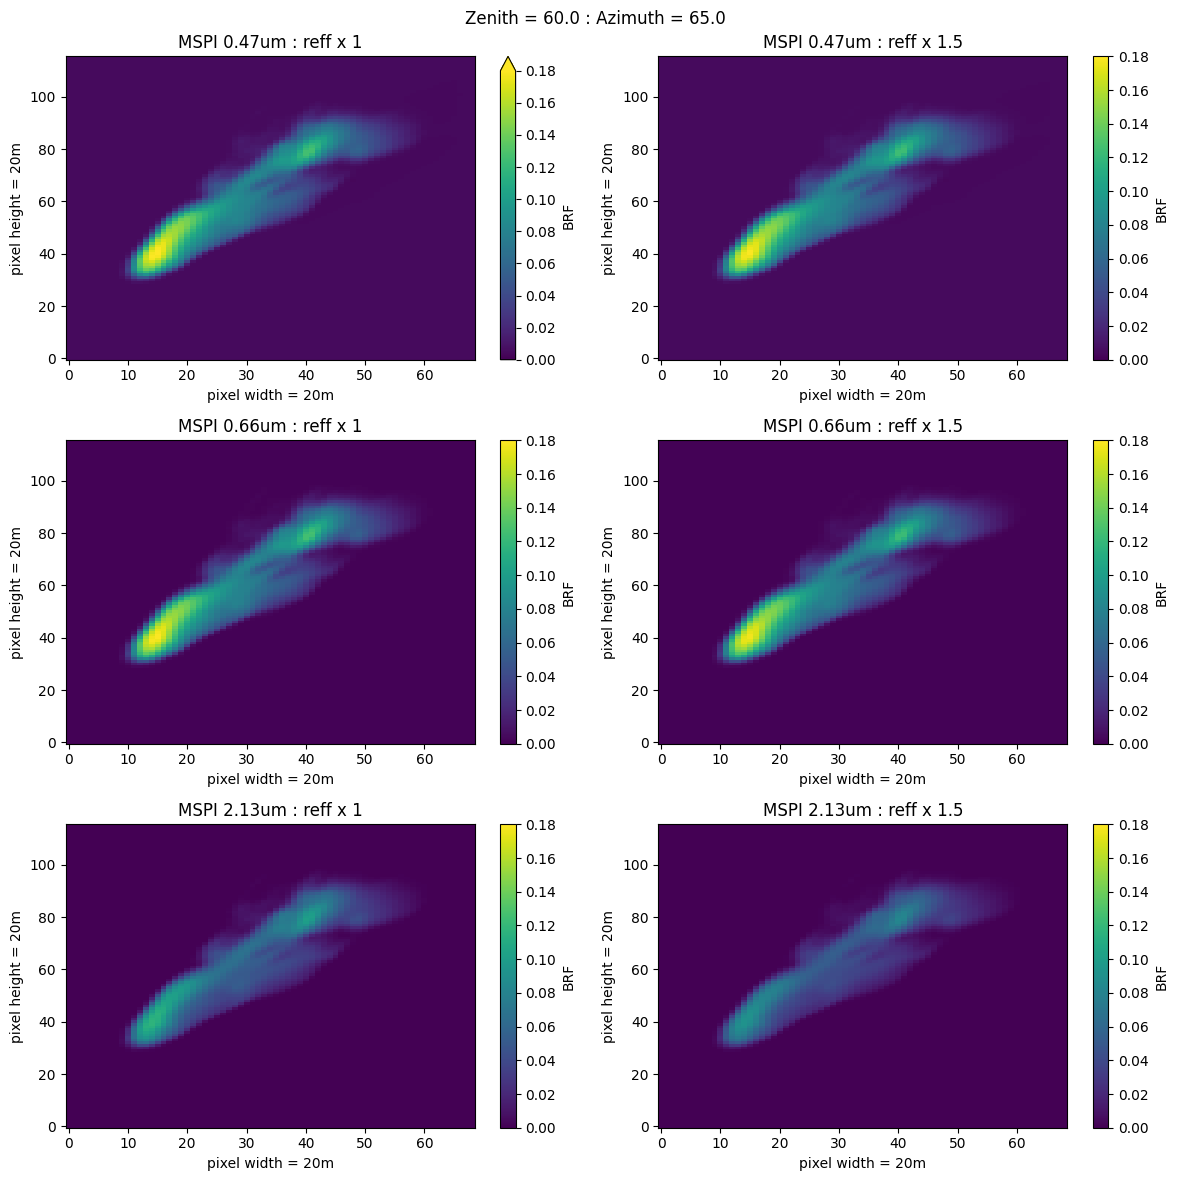

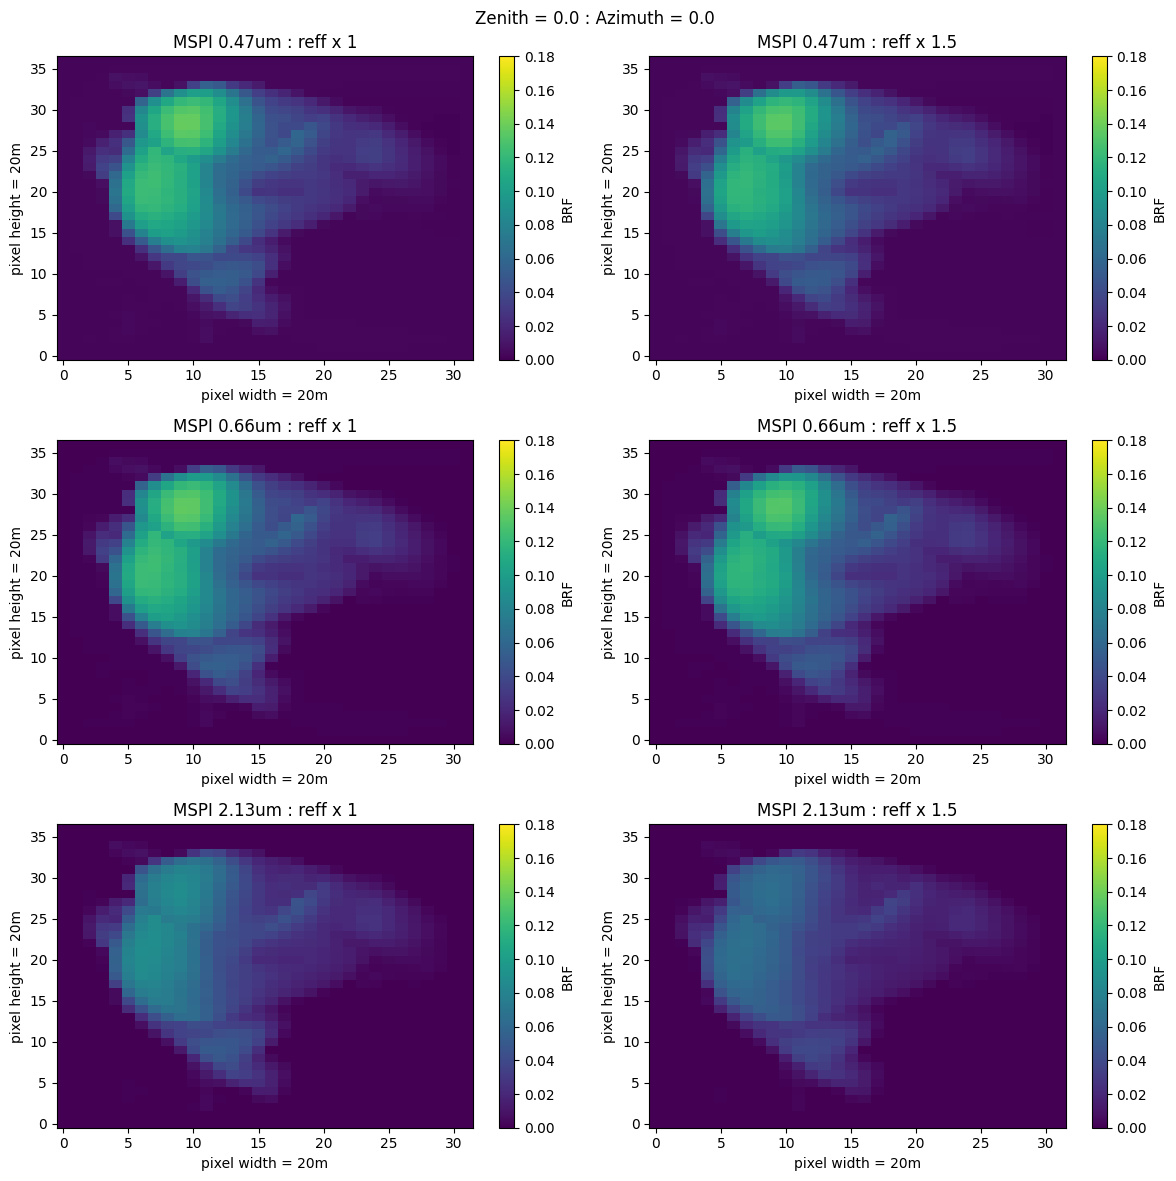

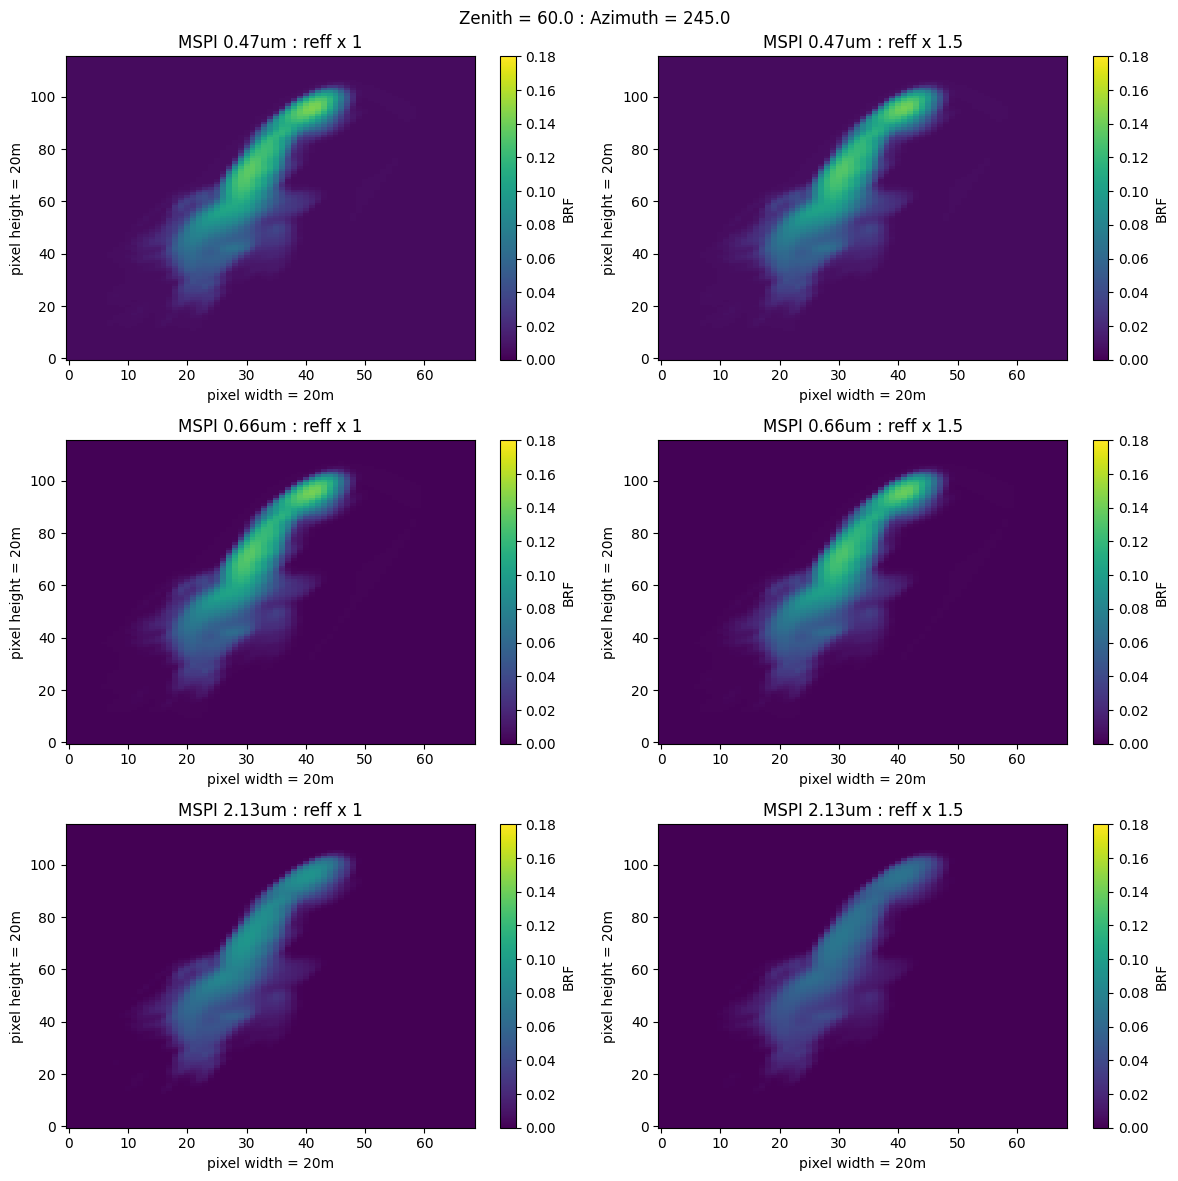

In [10]:
#plot
cmap = py.get_cmap('viridis')
cmap.set_under('white')
transpose = np.swapaxes(sensor_dicts_2D, 0, 1) # sensor_dicts_2D : reff x angle x wavelength | transpose : angle x reff x wavelength
for i,sensor_dicts in enumerate(transpose):
    fig, axs = py.subplots(len(wavelengths), len(multiplicities), figsize=(12, 12))  # Create a figure with subplots side by side
    py.suptitle("Zenith = " + str(sensor_zenith_list[i]) + " : Azimuth = " + str(sensor_azimuth_list[i]))
    for k,sensor_dict in enumerate(sensor_dicts):
        for instrument in sensor_dict:
            sensor_images = sensor_dict.get_images(instrument)
            for j,image in enumerate(sensor_images):
                plot = image.I.T.plot(ax=axs[j, k], vmin=0, vmax=.18, cmap=cmap)
                colorbar = plot.colorbar
                colorbar.set_label("BRF")
                axs[j, k].set_title(instrument + " " + str(wavelengths[j]) + "um : " + "reff x " + str(multiplicities[k]))
                axs[j, k].set_xlabel("pixel width = 20m")
                axs[j, k].set_ylabel("pixel height = 20m")
    py.tight_layout()  # Adjust layout for better spacing
    py.show()

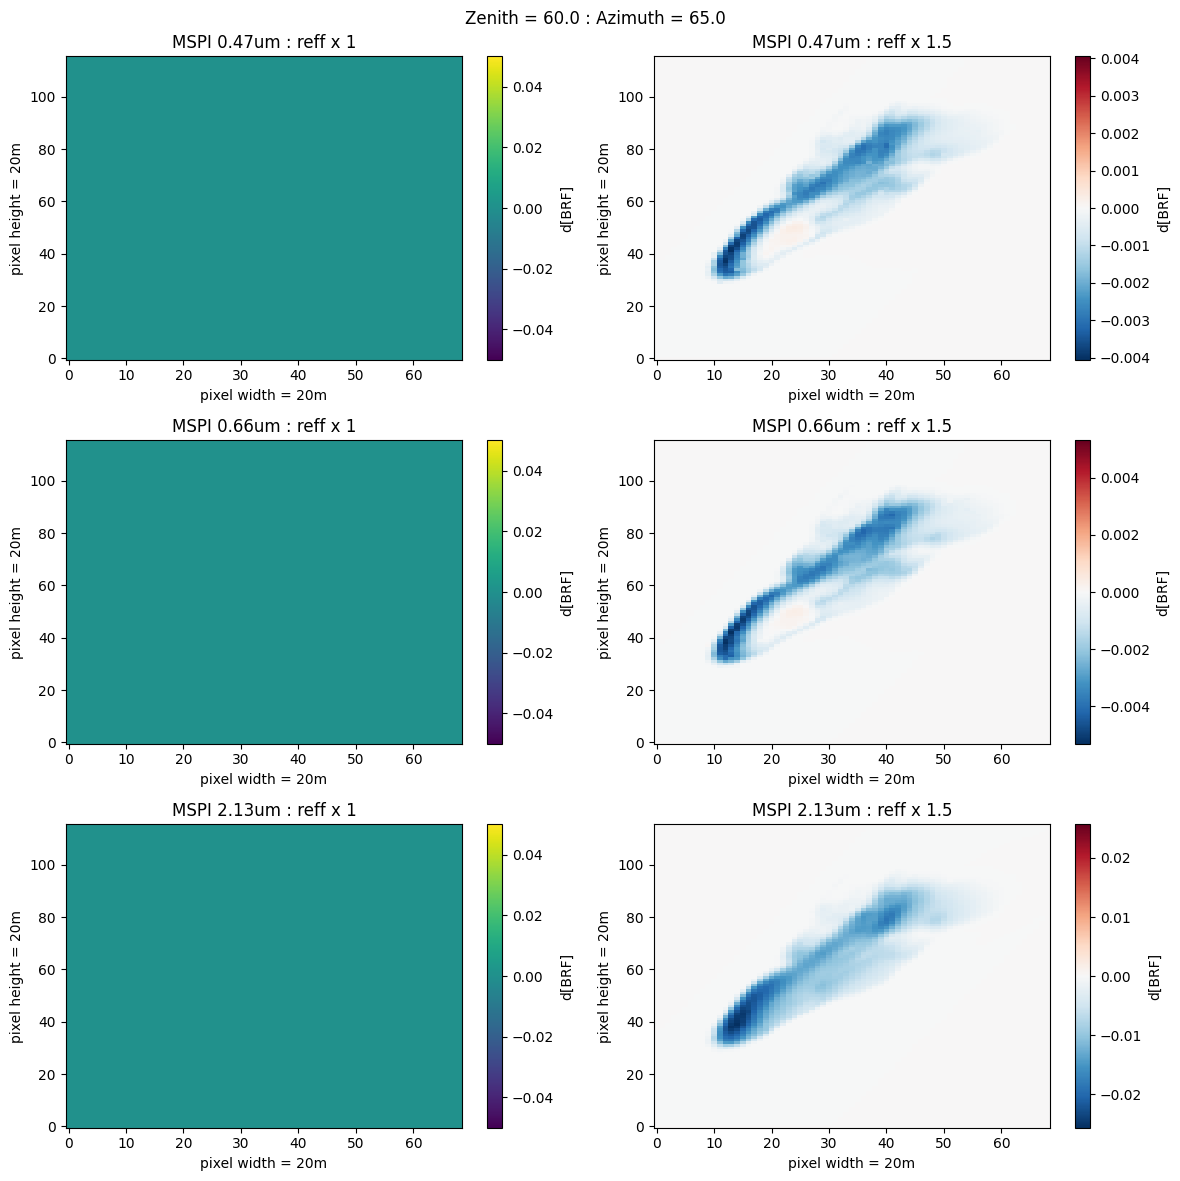

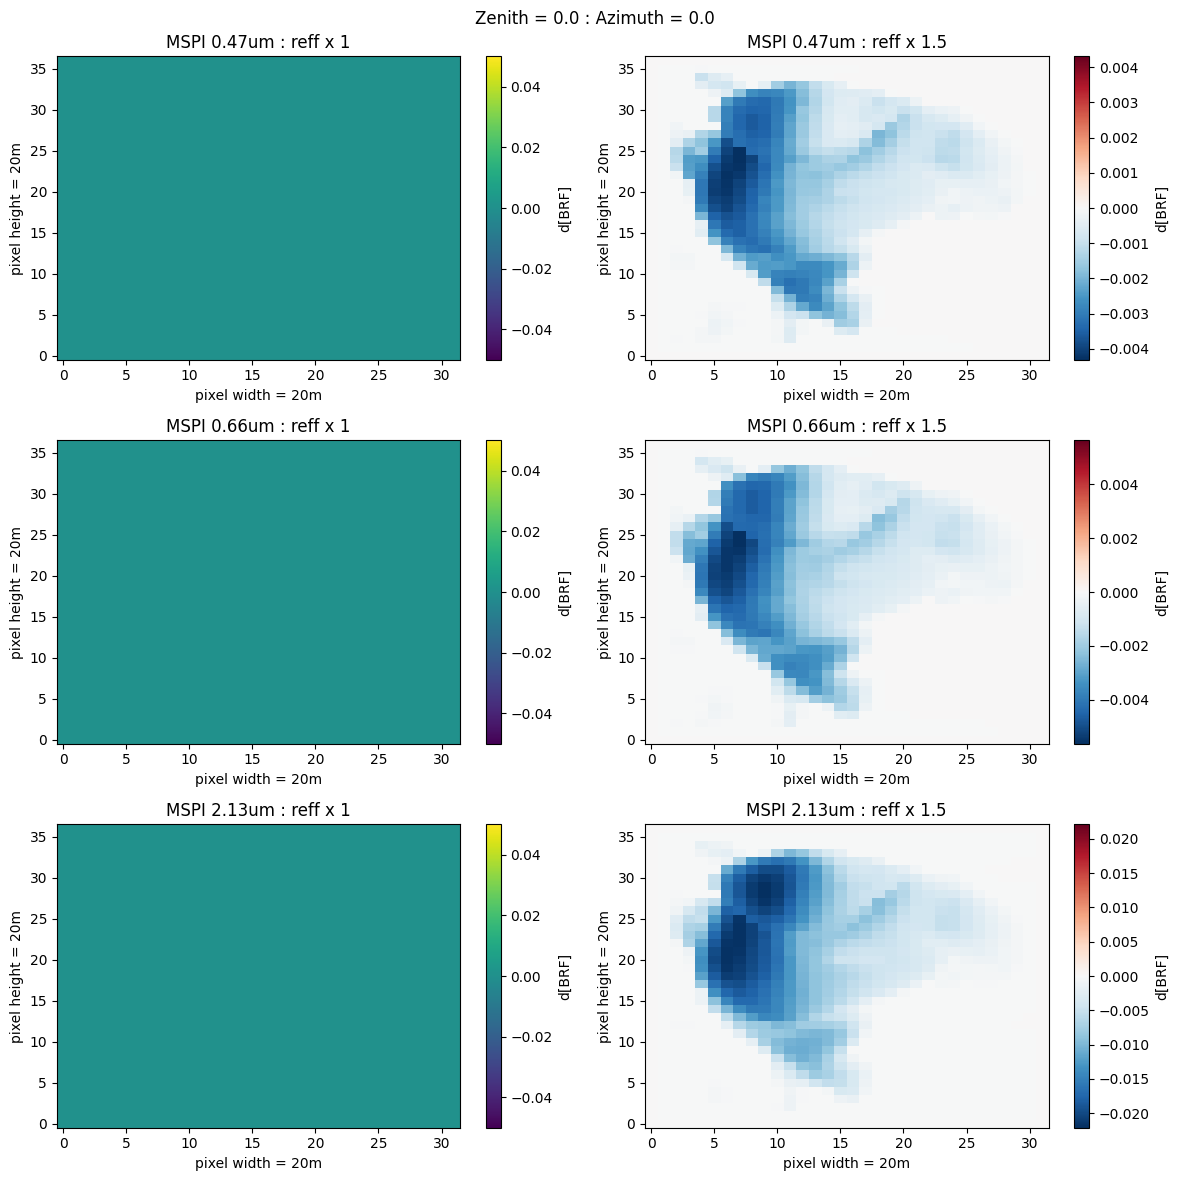

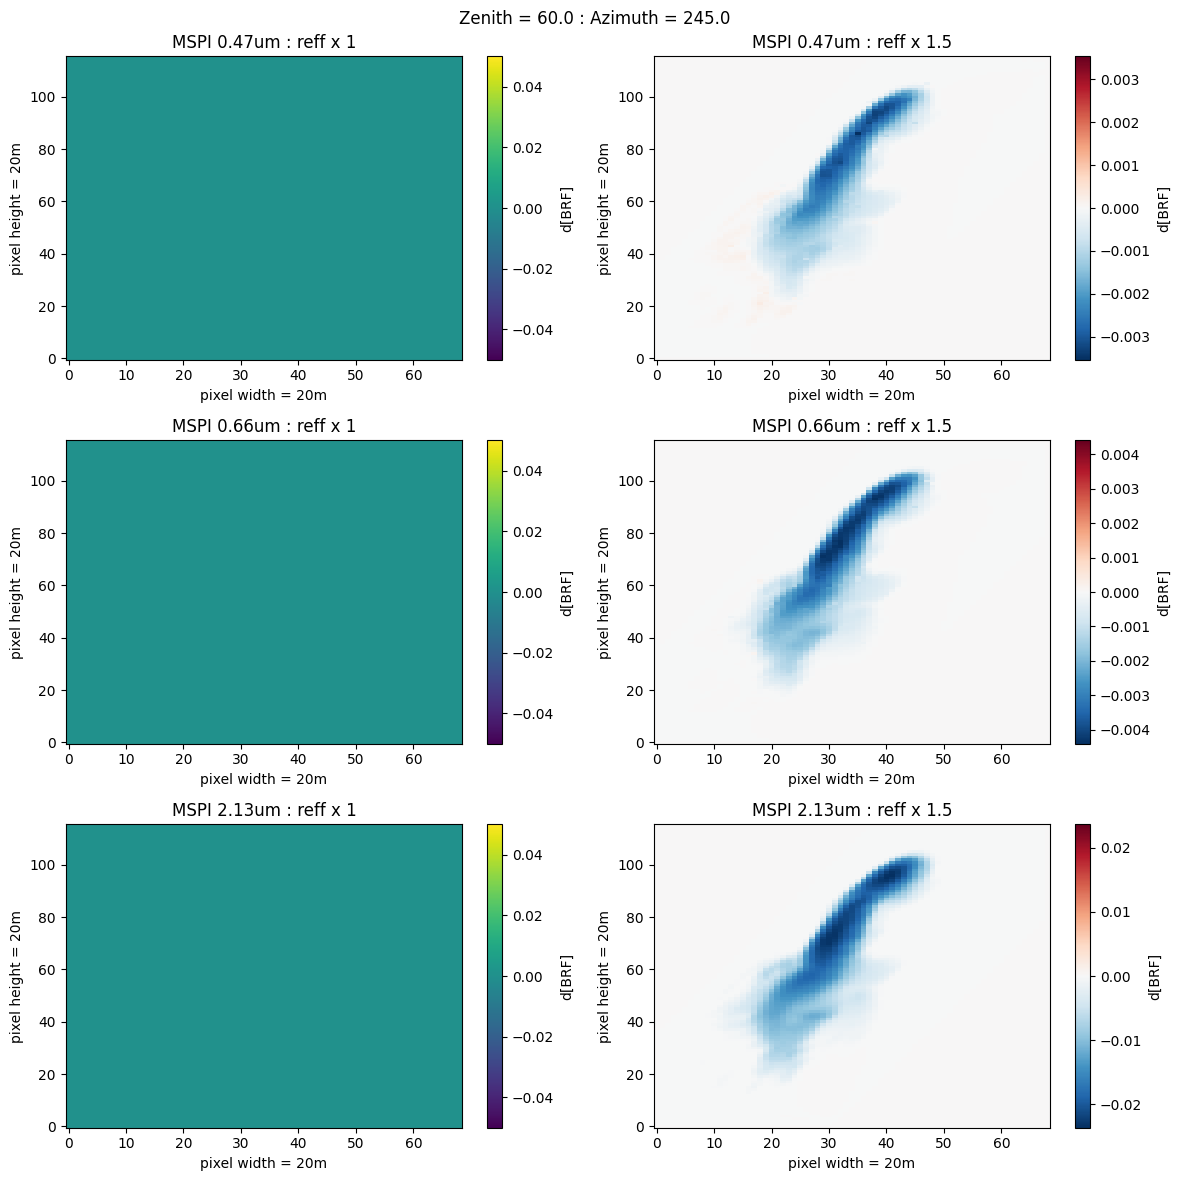

In [11]:
cmap = py.get_cmap('viridis')
cmap.set_under('white')
transpose = np.swapaxes(sensor_dicts_2D, 0, 1) # sensor_dicts_2D : reff x angle x wavelength | transpose : angle x reff x wavelength
for i,sensor_dicts in enumerate(transpose):
    fig, axs = py.subplots(len(wavelengths), len(multiplicities), figsize=(12, 12))  # Create a figure with subplots side by side
    py.suptitle("Zenith = " + str(sensor_zenith_list[i]) + " : Azimuth = " + str(sensor_azimuth_list[i]))
    base = sensor_dicts[0]
    base_images = base.get_images("MSPI")
    for k,sensor_dict in enumerate(sensor_dicts):
        for instrument in sensor_dict:
            sensor_images = sensor_dict.get_images(instrument)
            for j,image in enumerate(sensor_images):
                plot = (image.I.T-base_images[j].I.T).plot(ax=axs[j, k])#, vmin=0, vmax=.18, cmap=cmap)
                colorbar = plot.colorbar
                colorbar.set_label("d[BRF]")
                axs[j, k].set_title(instrument + " " + str(wavelengths[j]) + "um : " + "reff x " + str(multiplicities[k]))
                axs[j, k].set_xlabel("pixel width = 20m")
                axs[j, k].set_ylabel("pixel height = 20m")
    py.tight_layout()  # Adjust layout for better spacing
    py.show()

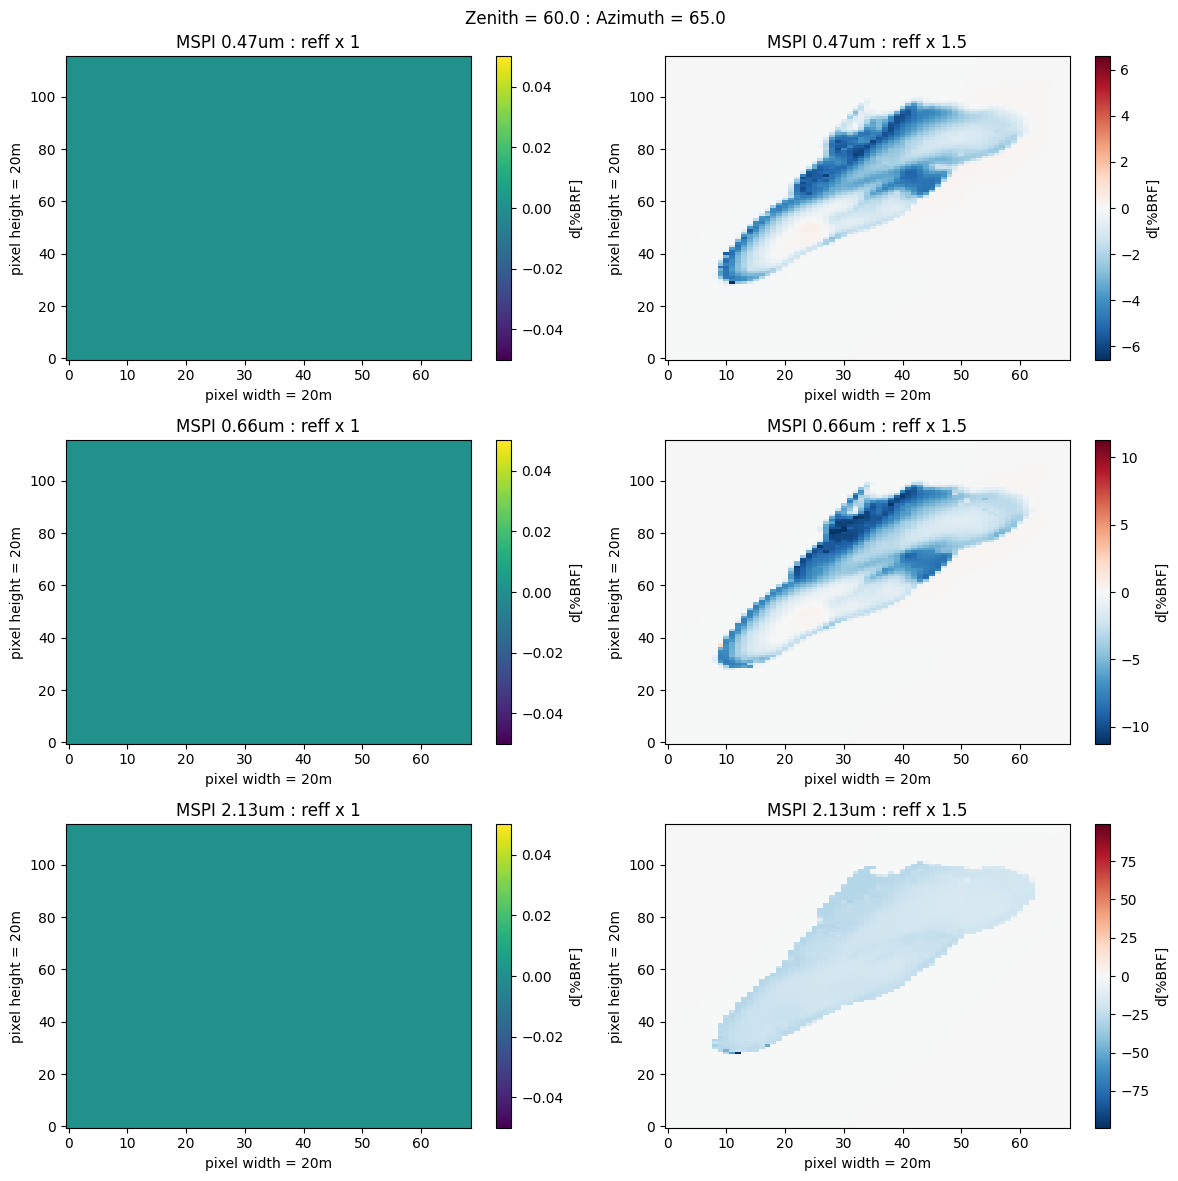

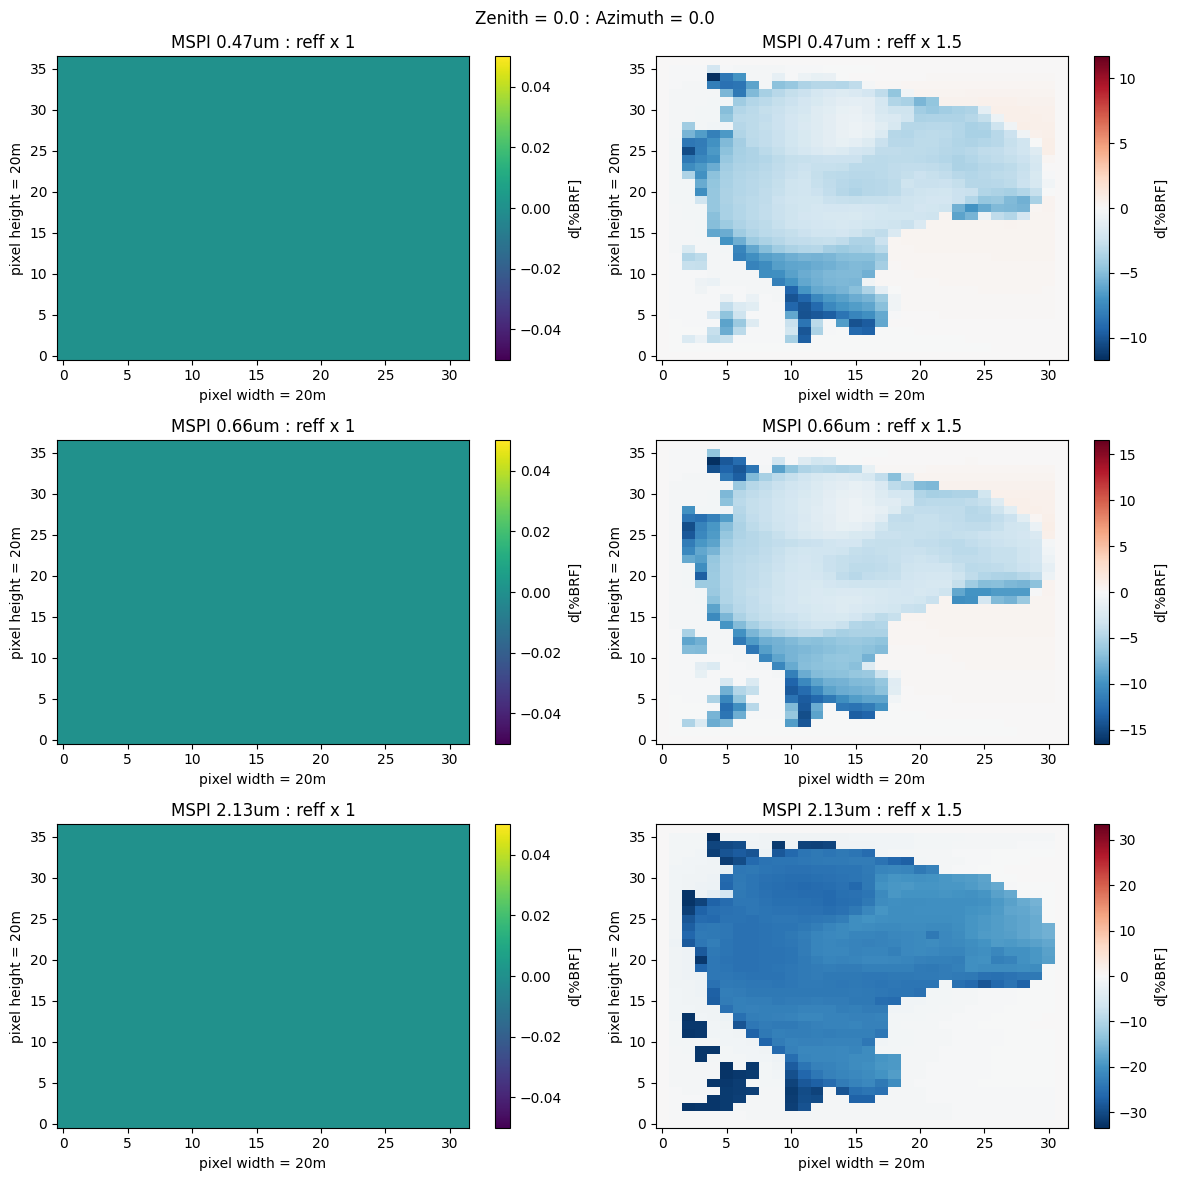

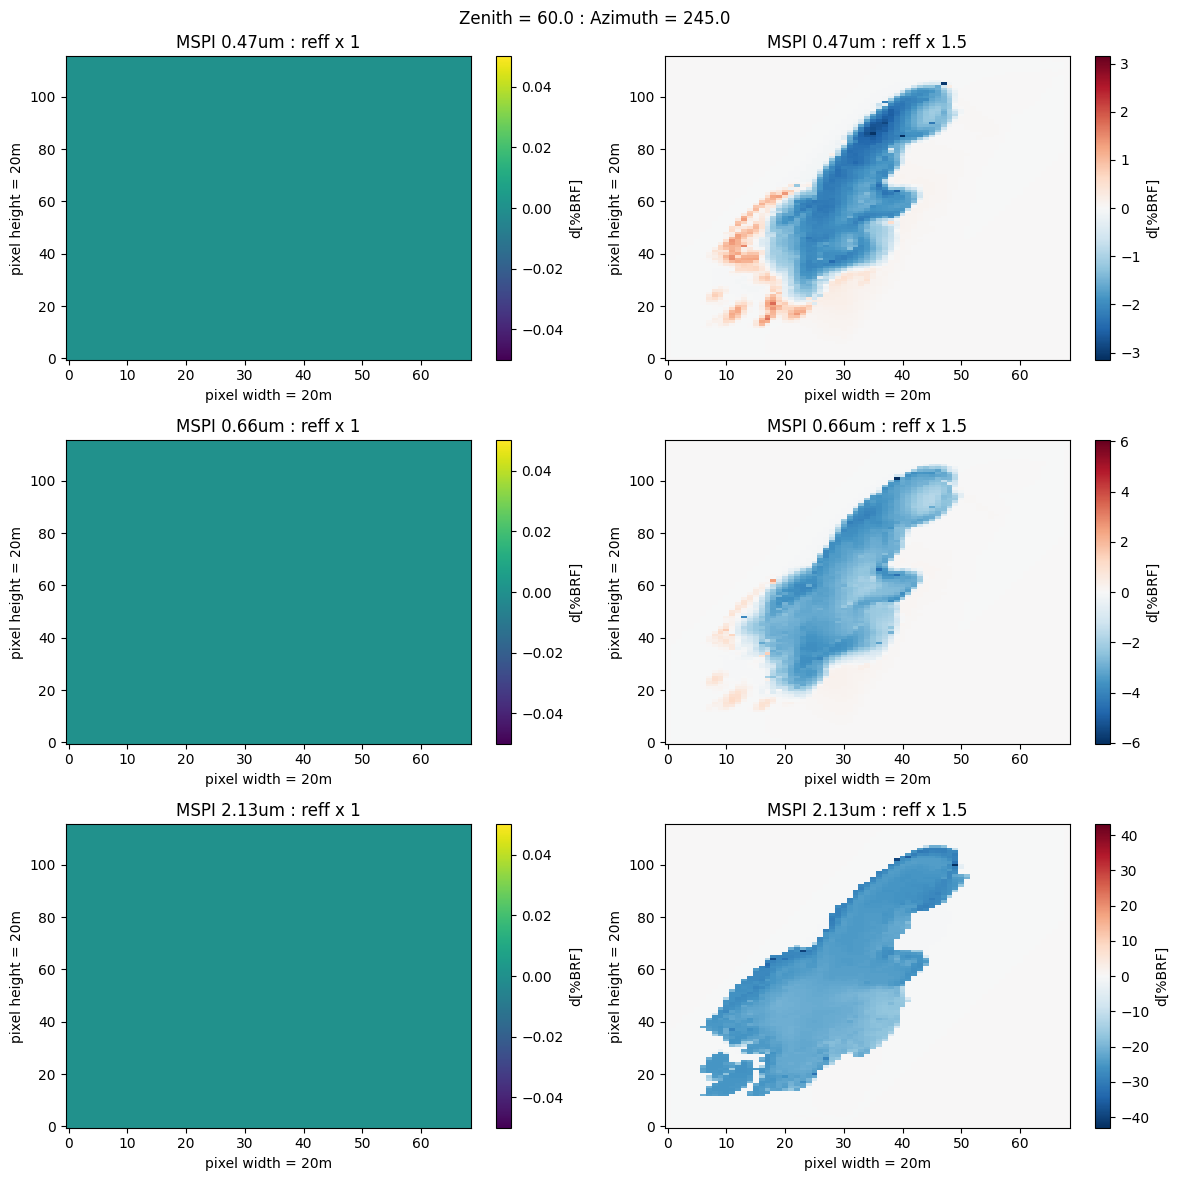

In [12]:
cmap = py.get_cmap('viridis')
cmap.set_under('white')
transpose = np.swapaxes(sensor_dicts_2D, 0, 1) # sensor_dicts_2D : reff x angle x wavelength | transpose : angle x reff x wavelength
for i,sensor_dicts in enumerate(transpose):
    fig, axs = py.subplots(len(wavelengths), len(multiplicities), figsize=(12, 12))  # Create a figure with subplots side by side
    py.suptitle("Zenith = " + str(sensor_zenith_list[i]) + " : Azimuth = " + str(sensor_azimuth_list[i]))
    base = sensor_dicts[0]
    base_images = base.get_images("MSPI")
    for k,sensor_dict in enumerate(sensor_dicts):
        for instrument in sensor_dict:
            sensor_images = sensor_dict.get_images(instrument)
            for j,image in enumerate(sensor_images):
                plot = ((image.I.T-base_images[j].I.T)/base_images[j].I.T*100).plot(ax=axs[j, k])#, vmin=0, vmax=.18, cmap=cmap)
                colorbar = plot.colorbar
                colorbar.set_label("d[%BRF]")
                axs[j, k].set_title(instrument + " " + str(wavelengths[j]) + "um : " + "reff x " + str(multiplicities[k]))
                axs[j, k].set_xlabel("pixel width = 20m")
                axs[j, k].set_ylabel("pixel height = 20m")
    py.tight_layout()  # Adjust layout for better spacing
    py.show()

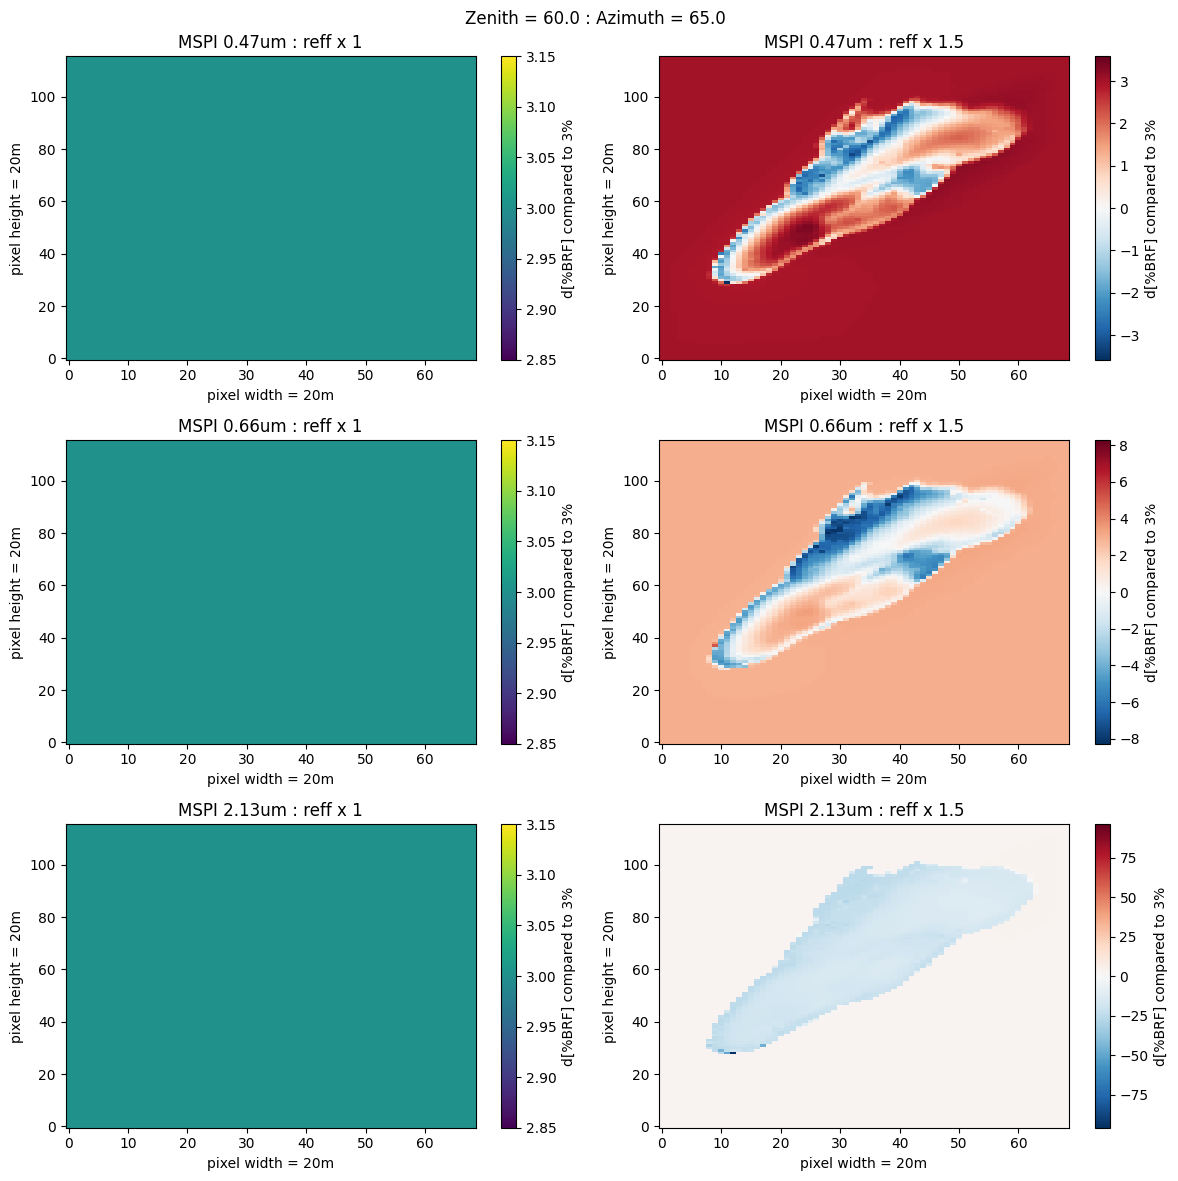

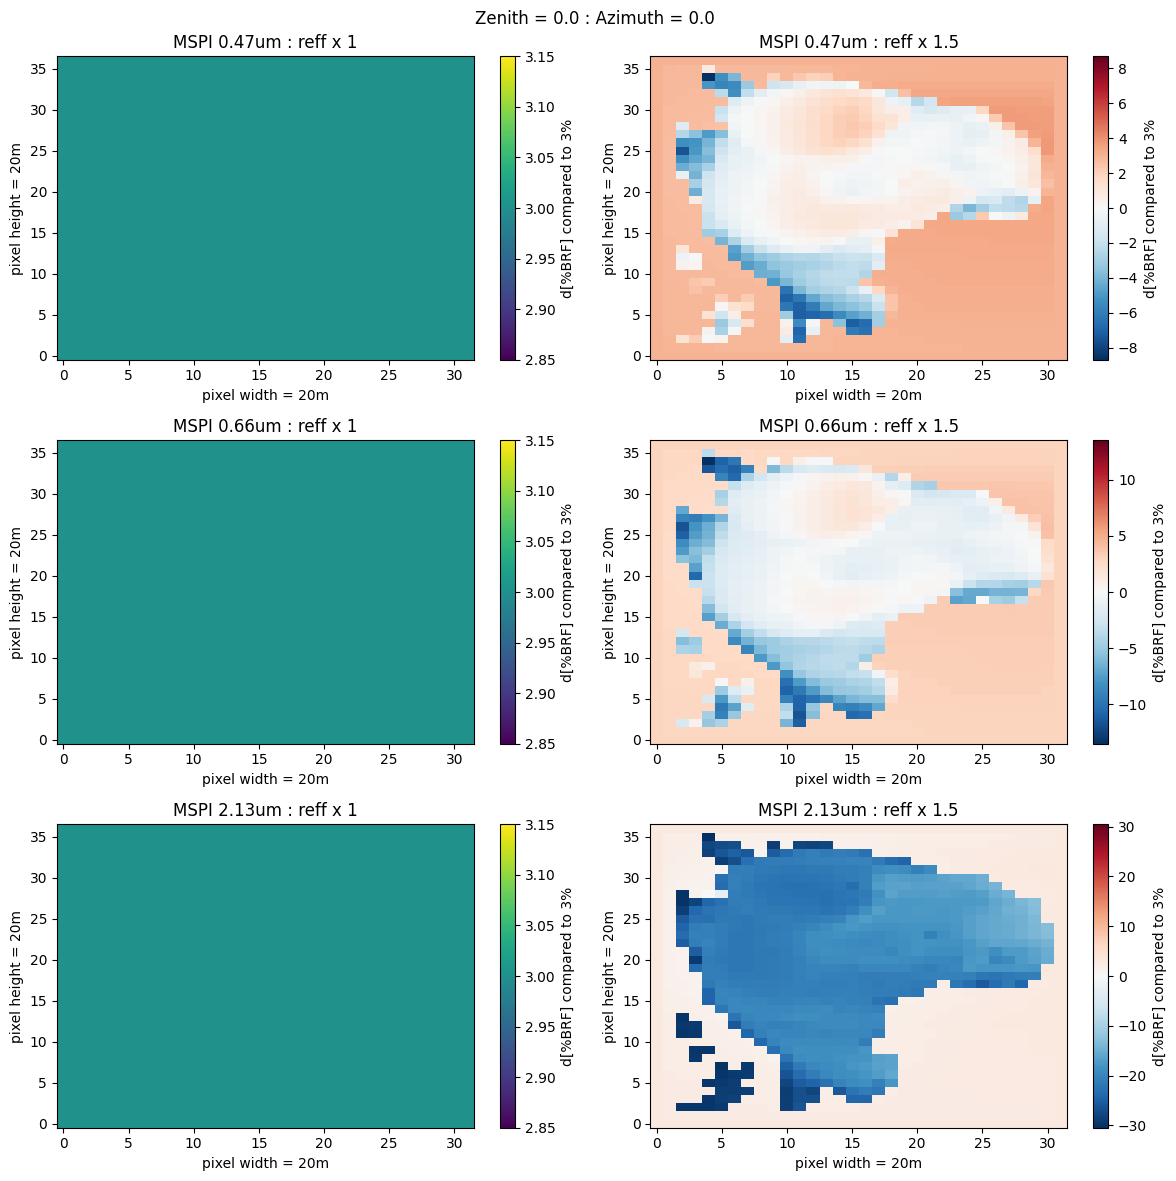

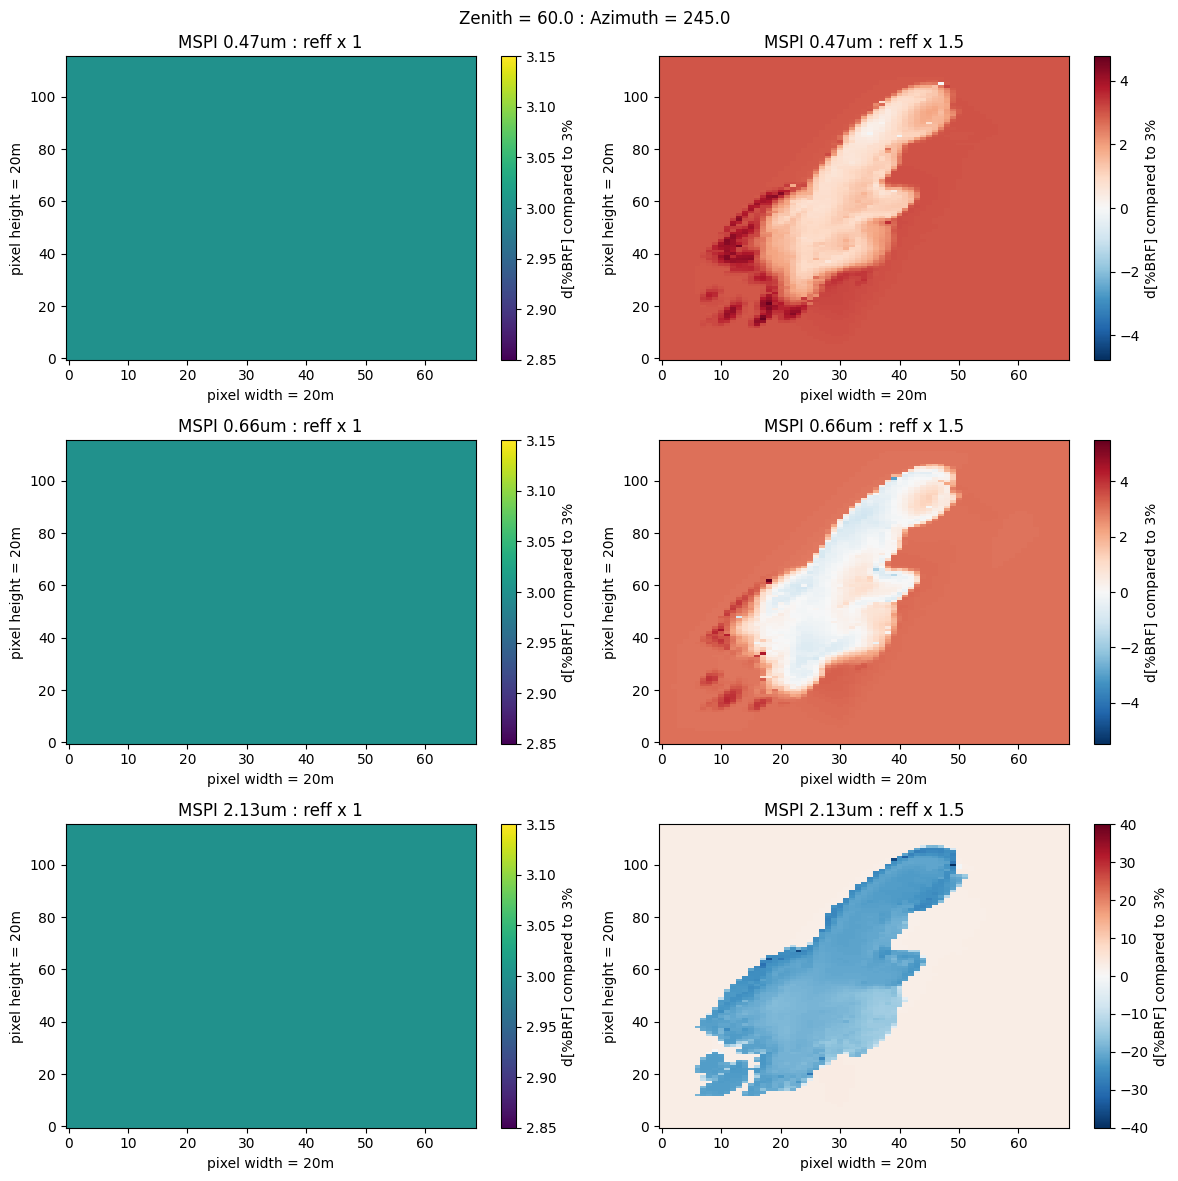

In [14]:
cmap = py.get_cmap('viridis')
cmap.set_under('white')
transpose = np.swapaxes(sensor_dicts_2D, 0, 1) # sensor_dicts_2D : reff x angle x wavelength | transpose : angle x reff x wavelength
for i,sensor_dicts in enumerate(transpose):
    fig, axs = py.subplots(len(wavelengths), len(multiplicities), figsize=(12, 12))  # Create a figure with subplots side by side
    py.suptitle("Zenith = " + str(sensor_zenith_list[i]) + " : Azimuth = " + str(sensor_azimuth_list[i]))
    base = sensor_dicts[0]
    base_images = base.get_images("MSPI")
    for k,sensor_dict in enumerate(sensor_dicts):
        for instrument in sensor_dict:
            sensor_images = sensor_dict.get_images(instrument)
            for j,image in enumerate(sensor_images):
                plot = (3+(image.I.T-base_images[j].I.T)/base_images[j].I.T*100).plot(ax=axs[j, k])#, vmin=0, vmax=.18, cmap=cmap)
                colorbar = plot.colorbar
                colorbar.set_label("d[%BRF] compared to 3%")
                axs[j, k].set_title(instrument + " " + str(wavelengths[j]) + "um : " + "reff x " + str(multiplicities[k]))
                axs[j, k].set_xlabel("pixel width = 20m")
                axs[j, k].set_ylabel("pixel height = 20m")
    py.tight_layout()  # Adjust layout for better spacing
    py.show()

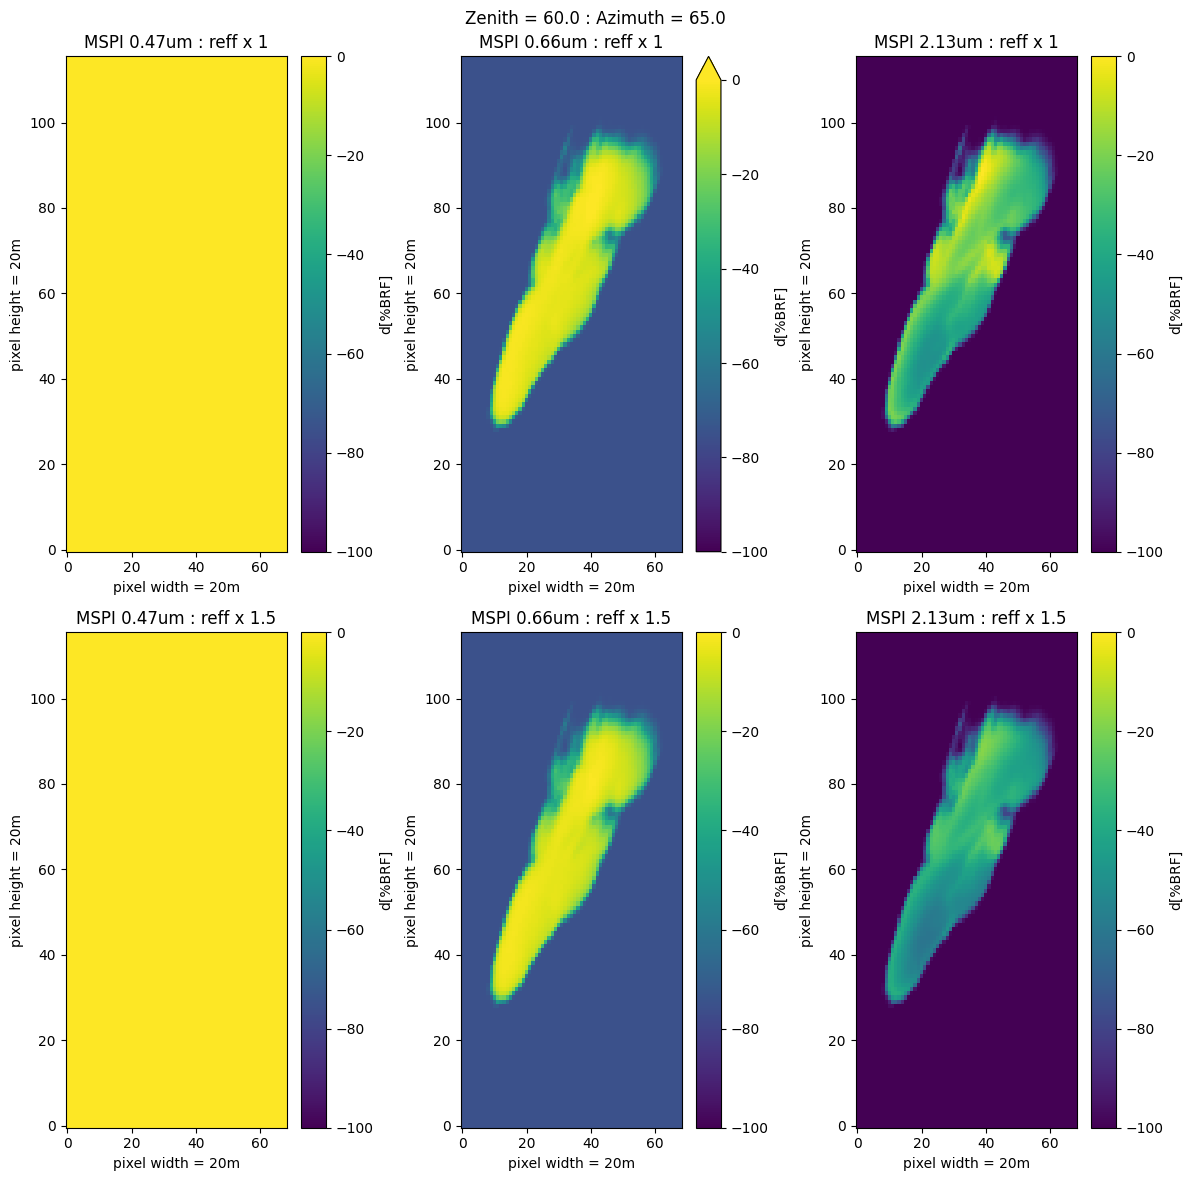

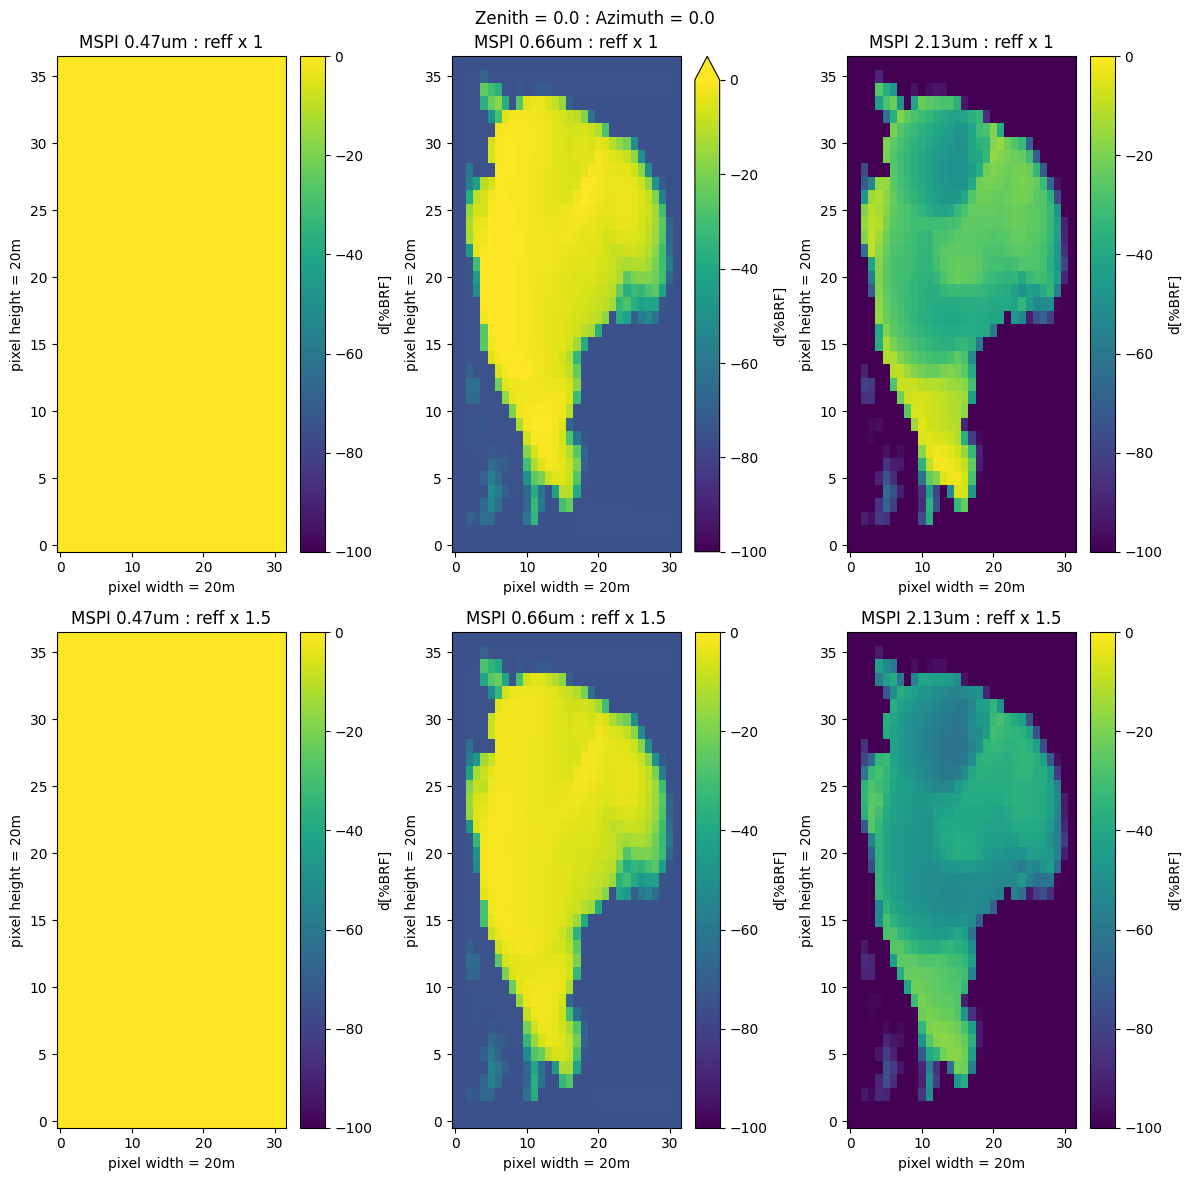

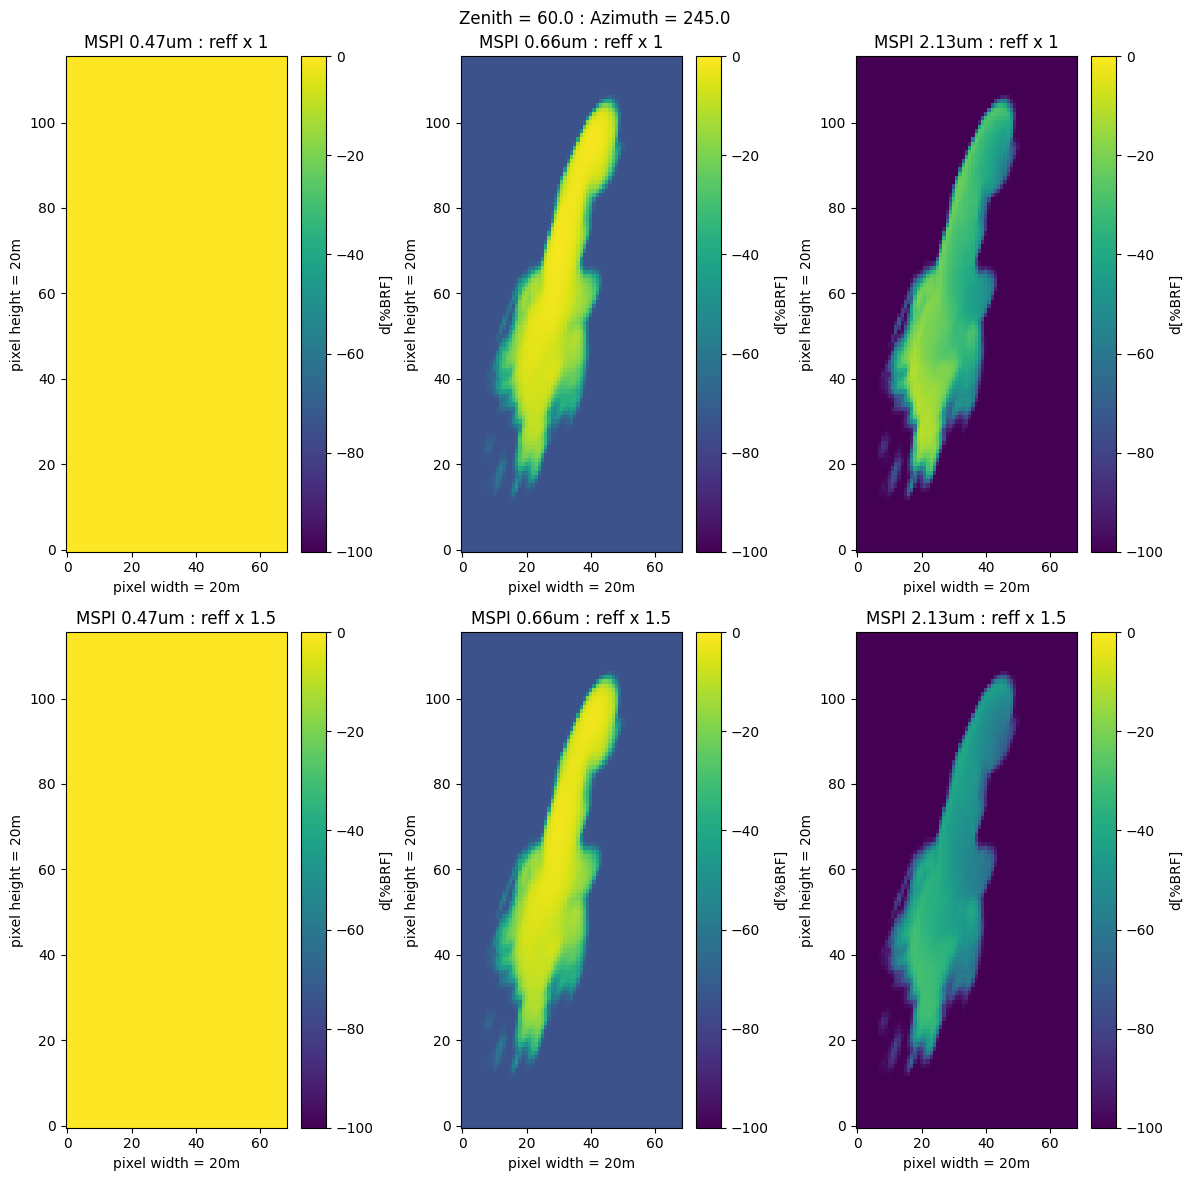

In [13]:
cmap = py.get_cmap('viridis')
cmap.set_under('white')
transpose = np.swapaxes(sensor_dicts_2D, 0, 1) # sensor_dicts_2D : reff x angle x wavelength | transpose : angle x reff x wavelength
for i,sensor_dicts in enumerate(transpose):
    fig, axs = py.subplots(len(multiplicities), len(wavelengths), figsize=(12, 12))  # Create a figure with subplots side by side
    py.suptitle("Zenith = " + str(sensor_zenith_list[i]) + " : Azimuth = " + str(sensor_azimuth_list[i]))
    for j,sensor_dict in enumerate(sensor_dicts):
        for instrument in sensor_dict:
            sensor_images = sensor_dict.get_images(instrument)
            for k,image in enumerate(sensor_images):
                plot = ((image.I.T-sensor_images[0].I.T)/sensor_images[0].I.T*100).plot(ax=axs[j, k], vmin=-100, vmax=0, cmap=cmap)
                colorbar = plot.colorbar
                colorbar.set_label("d[%BRF]")
                axs[j, k].set_title(instrument + " " + str(wavelengths[k]) + "um : " + "reff x " + str(multiplicities[j]))
                axs[j, k].set_xlabel("pixel width = 20m")
                axs[j, k].set_ylabel("pixel height = 20m")
    py.tight_layout()  # Adjust layout for better spacing
    py.show()